In [226]:
from scipy import integrate
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
import pickle as pickle
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:5]
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity

def getPos(path_LOS,linenumber=8):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=8):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

In [227]:

def low_region():
       """
       finds the low neutral fraction area. Calculate the optical depth until it's unity. Return the average length
       """
       sigma = 6.3e-18
       factor = 0.1453*3.086e24 /0.68
       neutral_fraction_limit = 1e-3

       total_tau = []
       for i in range(100):
              raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
              distance, pec_vel, temp, HI_density,gas_density, gas_metallicity = unPackRawFile(raw_path)
              #changing the distance from chimp to cemeters
              factor = 0.1453*3.086e24 /0.68
              distance_cm = distance *factor
              distance_graph = [0]
              HI_graph = [0]
              tau = []
              tau.append(0)
              k = 0
              while(integrate.cumtrapz(np.multiply(HI_graph,sigma),distance_graph,initial = 0)[-1] < 1.5 and k <len(distance)):
                     distance_graph.append(distance_cm[k])
                     HI_graph.append(HI_density[k])
                     tau.append(integrate.cumtrapz(np.multiply(HI_graph,sigma),distance_graph,initial = 0)[-1])
                     k+=1
              total_tau.append([tau,np.multiply(np.divide(distance_graph,factor),0.1453)])
       return total_tau


In [228]:
tau = low_region()

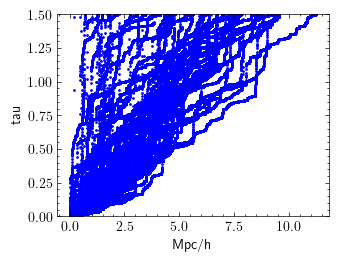

In [229]:
with plt.style.context('science','notebook'):
    for i in range(100):
        plt.scatter(tau[i][1],tau[i][0],c='blue',s=1)
        plt.xlabel("Mpc/h")
        plt.ylabel("tau")
        plt.ylim(0,1.5)
        plt.savefig("random_location.png")

In [230]:
def find_dense(file_path):
    '''find the starting distance'''
    distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(file_path)
    neutral_fraction_limit = 3e-3
    starting_distance = 0
    i=0
    while i < (len(distance)):
        if(HI_density[i]/gas_density[i] > neutral_fraction_limit):
            starting_distance = i
            break
        i+=1

    return starting_distance

def high_region():
       """
       finds the low neutral fraction area. Calculate the optical depth until it's unity. Return the average length
       """
       sigma = 6.3e-18
       factor = 0.1453*3.086e24 /0.68
       total_tau = []
       for i in range(100):
            raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
            distance, pec_vel, temp, HI_density,gas_density, gas_metallicity = unPackRawFile(raw_path)
            #changing the distance from chimp to cemeters
            factor = 0.1453*3.086e24 /0.68
            distance_cm = distance *factor
            starting_distance = find_dense(raw_path)
            distance_graph = [distance_cm[starting_distance]]
            HI_graph = [0]
            tau = []
            tau.append(0)
            k = starting_distance
            while(integrate.cumtrapz(np.multiply(HI_graph,sigma),distance_graph,initial = 0)[-1] < 1.5 and k <len(distance)):
                    distance_graph.append(distance_cm[k])
                    HI_graph.append(HI_density[k])
                    tau.append(integrate.cumtrapz(np.multiply(HI_graph,sigma),distance_graph,initial = 0)[-1])
                    k+=1
            mpch = np.multiply(np.divide(distance_graph,factor),0.1453)
            total_tau.append([tau,np.subtract(mpch,mpch[0])])
       return total_tau

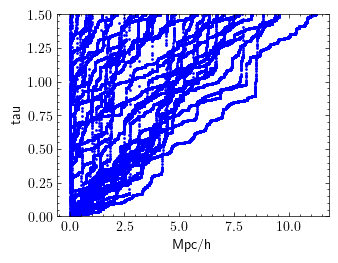

In [231]:
with plt.style.context('science','notebook'):
    tau_1 = high_region()
    for i in range(100):
        plt.scatter(tau_1[i][1],tau_1[i][0],c='blue',s=1)
        plt.xlabel("Mpc/h")
        plt.ylabel("tau")
        plt.ylim(0,1.5)
        plt.savefig('3e-3_neutral_fraction.png')

In [232]:
len(tau_1)

100

In [233]:
def average(tau):
    distance = []
    tau_value = []
    for i in tau:
        distance.append(i[1])
        tau_value.append(i[0])
    distance_all = []
    tau_value_all = []
    for i,k in zip(distance, tau_value):
        for z in i:
            distance_all.append(z)
        for p in k:
            tau_value_all.append(p)
    return distance_all, tau_value_all
    

In [234]:
def main():
    inputs = ['0.1409']
    for i in inputs:
        tau = low_region(i)
        all_distance, all_tau = average(tau)
        distance_mpc = np.divide(all_distance,3.086e24)
        p = np.poly1d(np.polyfit(distance_mpc,all_tau,4))
        with open('mfp_'+ i +'_new.pkl', 'wb') as f:
            pickle.dump(p, f, protocol=pickle.HIGHEST_PROTOCOL)